# Electron Photon tagging

This is a first test to implement a QAE. 
The task is to identify Electrons and Photons from em-calorimeter images.

### imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import QAE as qae

import warnings
warnings.filterwarnings('ignore')

2022-07-08 18:25:34.422736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 18:25:34.422758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-08 18:25:35.901391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-08 18:25:35.901416: W tensorflow/

## data 

In [2]:
data = np.load('../../data/electron-photon.npz', allow_pickle=True)
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

In [3]:
DOWNSCALE = 3
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)

In [4]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [5]:
x_train_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train]
x_test_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test]

x_train_circuit_electrons = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train_electrons]
x_test_circuit_electrons = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test_electrons]

In [6]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)

x_train_tf_electrons = tfq.convert_to_tensor(x_train_circuit_electrons)
x_test_tf_electrons = tfq.convert_to_tensor(x_test_circuit_electrons)

## SQAE model

In [7]:
model = qae.SQAE_model(9,LATENT_BITS,9)

In [8]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


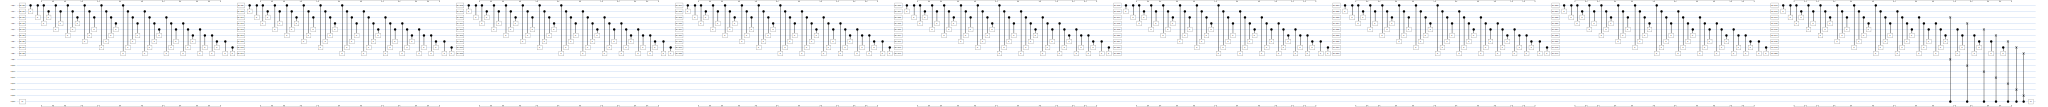

In [9]:
SVGCircuit(model.model_circuit)

In [10]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_electrons = np.ones(shape=len(x_train_tf_electrons))
y_test_ones_electrons = np.ones(shape=len(x_test_tf_electrons))

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(x_train_tf, y_train_ones, epochs=400, batch_size=16, validation_data=(x_test_tf, y_test_ones), callbacks=[es])

Epoch 1/400
3/3 [==============================] - 7s 2s/step - loss: 0.9837 - val_loss: 0.9772
Epoch 2/400
3/3 [==============================] - 7s 2s/step - loss: 0.9724 - val_loss: 0.9650
Epoch 3/400
3/3 [==============================] - 7s 2s/step - loss: 0.9584 - val_loss: 0.9507
Epoch 4/400
3/3 [==============================] - 7s 2s/step - loss: 0.9424 - val_loss: 0.9354
Epoch 5/400
3/3 [==============================] - 7s 2s/step - loss: 0.9259 - val_loss: 0.9197
Epoch 6/400
3/3 [==============================] - 7s 2s/step - loss: 0.9091 - val_loss: 0.9037
Epoch 7/400
3/3 [==============================] - 8s 3s/step - loss: 0.8921 - val_loss: 0.8873
Epoch 8/400
3/3 [==============================] - 7s 2s/step - loss: 0.8742 - val_loss: 0.8703
Epoch 9/400
3/3 [==============================] - 8s 3s/step - loss: 0.8557 - val_loss: 0.8523
Epoch 10/400
3/3 [==============================] - 8s 3s/step - loss: 0.8357 - val_loss: 0.8331
Epoch 11/400
3/3 [=====================

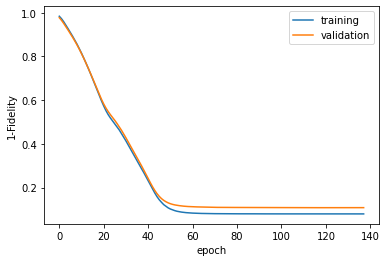

In [12]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
#plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("1-Fidelity")
plt.legend()

## Evaluation

0.7155716
0.7608716


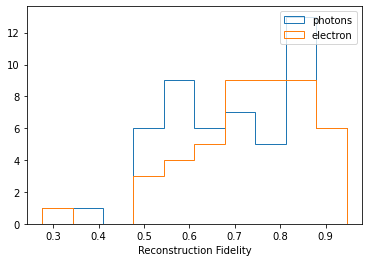

In [13]:
pred_photon = model.predict(x_test_tf)
print(np.median(pred_photon))
pred_electron = model.predict(x_test_tf_electrons)
print(np.median(pred_electron))
bins = np.histogram(np.hstack((pred_photon.reshape((pred_photon.shape[0],)), pred_electron.reshape((pred_electron.shape[0],)))), bins=10)[1]
plt.hist(pred_photon, histtype='step', label="photons",bins=bins)
plt.hist(pred_electron, histtype='step', label="electron",bins=bins)
plt.xlabel("Reconstruction Fidelity")
plt.legend()

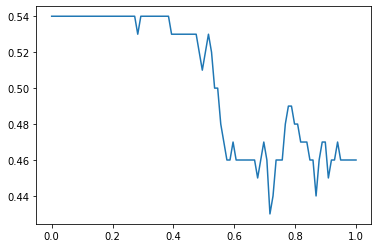

In [14]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_photon > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_electron < T)
    acc = (num_six_right + num_three_right)/(len(pred_photon) + len(pred_electron))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs)  